# Pipeline walkthrough

## Data import

In [1]:
from preprocessing.import_data import import_save_dataset

import napari

trim_series = True
lif_test_name = "test_data/2021-06-14/p2pdpwt"
lsm_test_name = "test_data/2023-04-07/p2pdp_zld-sites-ctrl_fwd_1"
var1_test_name = "test_data/2023-06-16/RBSPWM_embryo01"

(
    channels_full_dataset,
    original_global_metadata,
    original_frame_metadata,
    export_global_metadata,
    export_frame_metadata,
) = import_save_dataset(var1_test_name, trim_series=trim_series, mode="tiff")

/home/yovan/mambaforge/envs/transcription_pipeline/lib/python3.10/site-packages/pims/bioformats.py:410: UserWarning: Due to an issue with JPype 0.6.0, reading is slower. Please consider upgrading JPype to 0.6.1 or later.
  warn('Due to an issue with JPype 0.6.0, reading is slower. '


The series in ['Series001', 'Series002', 'Series003'] have inconsistent ChannelPinholeSize, check your imaging settings and metadata.
The series in ['Series001', 'Series002', 'Series003'] have inconsistent LaserID, check your imaging settings and metadata.


/home/yovan/Documents/Berkeley/github_repositories/transcription_pipeline/preprocessing/import_data.py:719: UserWarning: /home/yovan/Documents/Berkeley/github_repositories/transcription_pipeline/test_data/2023-06-16/RBSPWM_embryo01/collated_dataset/collated_dataset_ch00.tiff is a low contrast image
  imsave(collated_data_path, channel_data, plugin="tifffile")
/home/yovan/Documents/Berkeley/github_repositories/transcription_pipeline/preprocessing/import_data.py:719: UserWarning: /home/yovan/Documents/Berkeley/github_repositories/transcription_pipeline/test_data/2023-06-16/RBSPWM_embryo01/collated_dataset/collated_dataset_ch01.tiff is a low contrast image
  imsave(collated_data_path, channel_data, plugin="tifffile")


In [2]:
nuclear_channel_metadata = export_frame_metadata[1]
nuclear_channel = channels_full_dataset[1]

## Starting a Dask Client for parallelization

In [3]:
from dask.distributed import LocalCluster, Client

In [4]:
cluster = LocalCluster(
    host="localhost",
    scheduler_port=8786,
    threads_per_worker=1,
    n_workers=12,
    memory_limit="4GB",
)

In [5]:
client = Client(cluster)

In [6]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 12
Total threads: 12,Total memory: 44.70 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:8786,Workers: 12
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 44.70 GiB
Comm: tcp://127.0.0.1:38913,Total threads: 1
Dashboard: http://127.0.0.1:39761/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:44537,


## Nuclear segmentation and tracking

In [7]:
import pipeline

In [8]:
%%time

nuclear_tracking = pipeline.Nuclear(
    data=nuclear_channel,
    global_metadata=export_global_metadata[1],
    frame_metadata=nuclear_channel_metadata,
    client=client,
)

CPU times: user 3.58 ms, sys: 28 µs, total: 3.6 ms
Wall time: 2.94 ms


/home/yovan/Documents/Berkeley/github_repositories/transcription_pipeline/pipeline.py:40: UserWarning: Resolution is anisotropic in X and Y, segmentation parameters should be handled manually.
  warnings.warn(


In [9]:
%%time

nuclear_tracking.track_nuclei()

Frame 36: 324 trajectories present.


SubnetOversizeException: search_range (aka maxdisp) too large for reasonable performance on these data (sub net contains 146 points)

In [16]:
nuclear_tracking.default_params

{'denoise_params': {'denoising': 'gaussian',
  'denoising_sigma': array([0.94679453, 1.15978779, 1.15978755])},
 'binarize_params': {'thresholding': 'global_otsu',
  'closing_footprint': array([[[False,  True, False],
          [ True,  True,  True],
          [False,  True, False]],
  
         [[ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True]],
  
         [[False,  True, False],
          [ True,  True,  True],
          [False,  True, False]]]),
  'cc_min_span': array([ 0.        , 46.39151144, 46.39150213]),
  'background_max_span': array([   9,  256, 1024]),
  'background_sigma': array([ 0.37871781, 46.39151144, 46.39150213]),
  'background_threshold_method': 'otsu',
  'background_dilation_footprint': array([[[False,  True, False],
          [ True,  True,  True],
          [False,  True, False]],
  
         [[ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True]],
  
         [[False,  True, False],
       

In [10]:
viewer = napari.view_image(nuclear_channel)
napari.run()

In [11]:
labels = nuclear_tracking.labels_futures

In [12]:
import numpy as np

In [13]:
labels = np.concatenate(client.gather(labels))

In [14]:
labels = labels.reshape(nuclear_channel.shape)

In [15]:
viewer.add_labels(labels)

<Labels layer 'labels' at 0x7f9819661300>

In [10]:
viewer.add_labels(nuclear_tracking.reordered_labels)

<Labels layer 'Labels' at 0x7ff6fdfc5810>

In [13]:
cluster.close()

In [184]:
nuclear_tracking = pipeline.Nuclear(
    data=nuclear_channel,
    global_metadata=export_global_metadata[1],
    frame_metadata=nuclear_channel_metadata,
    client=client,
)

/home/ybadal/Documents/Berkeley/github_repositories/transcription_pipeline/pipeline.py:40: UserWarning: Resolution is anisotropic in X and Y, segmentation parameters should be handled manually.
  warnings.warn(


In [22]:
mask = nuclear_tracking.reordered_labels > 0

In [15]:
from skimage.segmentation import expand_labels

In [ ]:
expand_labels(mask[20])

In [185]:
nuclear_tracking.default_params

{'denoise_params': {'denoising': 'gaussian',
  'denoising_sigma': array([1.06725195, 2.        , 2.        ])},
 'binarize_params': {'thresholding': 'global_otsu',
  'closing_footprint': array([[[False,  True, False],
          [ True,  True,  True],
          [False,  True, False]],
  
         [[ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True]],
  
         [[False,  True, False],
          [ True,  True,  True],
          [False,  True, False]]]),
  'cc_min_span': array([ 0.        , 39.54547443, 39.54547213]),
  'background_max_span': array([  5, 256, 512]),
  'background_sigma': array([ 0.80043896, 39.54547443, 39.54547213]),
  'background_threshold_method': 'li'},
 'mark_params': {'low_sigma': array([4.37131119, 5.39908673, 5.39908641]),
  'high_sigma': array([21.85655594, 26.99543364, 26.99543207]),
  'max_footprint': ((1, 20),
   array([[[False,  True, False],
           [ True,  True,  True],
           [False,  True, False]],
   
        

In [9]:
nuclear_segmentation = nuclear_tracking.reordered_labels

AttributeError: 'Nuclear' object has no attribute 'reordered_labels'

In [11]:
viewer = napari.view_image(nuclear_channel)
viewer.add_labels(nuclear_segmentation)
napari.run()

In [14]:
import numpy as np

In [15]:
nuclear_segmentation = np.concatenate(client.gather(nuclear_segmentation))

In [12]:
nuclear_labels_futures = nuclear_tracking.reordered_labels_futures

AttributeError: 'Nuclear' object has no attribute 'reordered_labels_futures'

In [16]:
test_mask = client.gather(nuclear_tracking.mask_futures)

In [17]:
import numpy as np

In [18]:
test_mask = np.concatenate(test_mask)

TypeError: dispatcher for __array_function__ did not return an iterable

In [22]:
viewer.add_image(frame_test)

<Image layer 'frame_test' at 0x7fec1c5cb5e0>

In [20]:
viewer.add_labels(nuclear_segmentation)

<Labels layer 'nuclear_segmentation' at 0x7fa11bf123b0>

In [24]:
from nuclear_analysis.segmentation import ellipsoid

In [31]:
from skimage.filters import difference_of_gaussians
import numpy as np

In [41]:
low_sigma = np.array([1.17057978, 10.33376631, 10.33376504])
high_sigma = np.array([10.8528989, 15.66883155, 15.6688252])

In [42]:
dog_test = difference_of_gaussians(
    frame_test, low_sigma=low_sigma, high_sigma=high_sigma
)

In [43]:
viewer.add_image(dog_test)

<Image layer 'dog_test' at 0x7fec8e44a6e0>

In [44]:
import matplotlib.pyplot as plt

(array([1.068612e+06, 0.000000e+00, 9.781400e+05, 0.000000e+00,
        4.765800e+05, 0.000000e+00, 1.658520e+05, 0.000000e+00,
        4.731100e+04, 0.000000e+00, 0.000000e+00, 1.184000e+04,
        0.000000e+00, 2.890000e+03, 0.000000e+00, 7.100000e+02,
        0.000000e+00, 2.130000e+02, 0.000000e+00, 0.000000e+00,
        1.140000e+02, 0.000000e+00, 6.800000e+01, 0.000000e+00,
        4.200000e+01, 0.000000e+00, 3.200000e+01, 0.000000e+00,
        2.900000e+01, 0.000000e+00, 0.000000e+00, 1.100000e+01,
        0.000000e+00, 2.000000e+01, 0.000000e+00, 1.000000e+01,
        0.000000e+00, 1.300000e+01, 0.000000e+00, 0.000000e+00,
        1.000000e+01, 0.000000e+00, 2.000000e+00, 0.000000e+00,
        3.000000e+00, 0.000000e+00, 4.000000e+00, 0.000000e+00,
        3.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00,
        0.000000e+00, 0.000000e+00, 0.000000e+00, 1.000000e+00]),
 array([ 0.  ,  0.45,  0.9 ,  1.35,  1

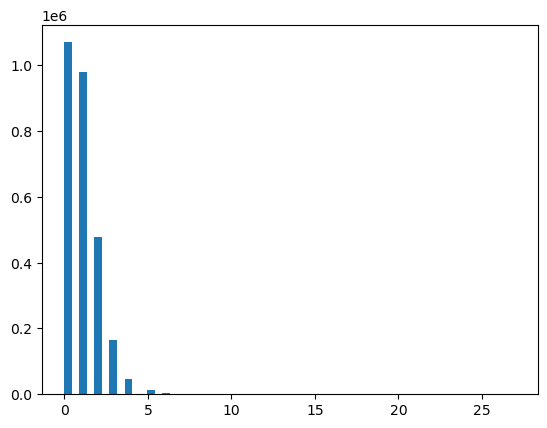

In [51]:
plt.hist(frame_test.flatten(), bins=60)

(array([5.00000e+00, 1.30000e+01, 2.10000e+01, 3.30000e+01, 4.90000e+01,
        6.40000e+01, 8.20000e+01, 1.06000e+02, 1.17000e+02, 1.64000e+02,
        1.80000e+02, 2.10000e+02, 2.61000e+02, 3.11000e+02, 3.58000e+02,
        4.39000e+02, 5.26000e+02, 6.88000e+02, 1.11600e+03, 1.32700e+03,
        1.53000e+03, 1.86200e+03, 1.59400e+03, 1.45700e+03, 1.48000e+03,
        1.62200e+03, 1.92500e+03, 2.30800e+03, 3.47500e+03, 7.45000e+03,
        1.89410e+04, 4.08570e+04, 6.50630e+04, 8.57320e+04, 1.00173e+05,
        1.05078e+05, 1.05872e+05, 1.05914e+05, 1.04961e+05, 1.04884e+05,
        1.04332e+05, 1.02627e+05, 1.00856e+05, 9.89930e+04, 9.79360e+04,
        9.65090e+04, 9.50500e+04, 9.09530e+04, 9.05590e+04, 8.80150e+04,
        8.53600e+04, 8.28960e+04, 7.67920e+04, 7.08450e+04, 6.52300e+04,
        5.75310e+04, 5.20230e+04, 4.64750e+04, 4.24070e+04, 3.91360e+04,
        3.48890e+04, 3.02030e+04, 2.70140e+04, 2.50990e+04, 2.30080e+04,
        1.99880e+04, 1.81730e+04, 1.49860e+04, 1.37

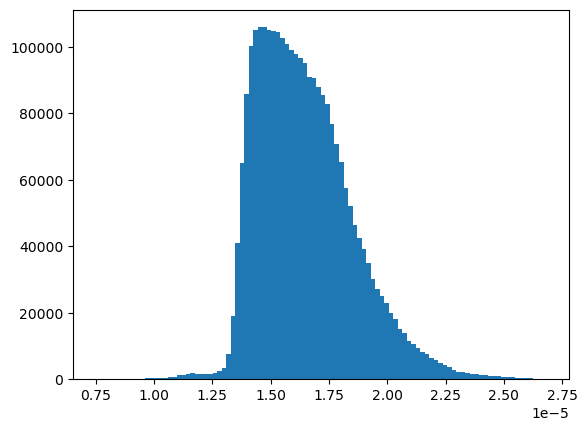

In [59]:
plt.hist(gaussian_test.flatten(), bins=100, log=False)

In [92]:
frame_test.shape

(21, 256, 512)

In [17]:
frame_test = nuclear_channel[34]

In [126]:
frame_test = frame_test[:19]

In [4]:
viewer = napari.view_image(frame_test)
napari.run()

In [127]:
viewer.add_image(frame_test)

<Image layer 'frame_test' at 0x7f3e9475f370>

In [5]:
from skimage.filters import gaussian

In [6]:
gaussian_test = gaussian(frame_test, sigma=[0.5, 30, 30])

In [7]:
viewer.add_image(gaussian_test)

<Image layer 'gaussian_test' at 0x7f3e3c4f2c50>

In [19]:
from skimage.filters import threshold_otsu, threshold_li, threshold_triangle

In [9]:
test_threshold = threshold_otsu(gaussian_test)

In [10]:
test_threshold

1.7551364506959035e-05

In [11]:
otsu = gaussian_test > test_threshold

In [17]:
viewer.add_labels(otsu)

<Labels layer 'otsu' at 0x7f3e9a383c10>

In [16]:
li = gaussian_test > threshold_li(gaussian_test, initial_guess=test_threshold)

In [18]:
viewer.add_labels(li)

<Labels layer 'li' at 0x7f3e99f01c00>

In [20]:
triangle = gaussian_test > threshold_triangle(gaussian_test)

In [21]:
viewer.add_labels(triangle)

<Labels layer 'triangle' at 0x7f3e9a0fa380>

In [36]:
from skimage.measure import label, regionprops
import numpy as np

In [53]:
labelled_lowpass = label(otsu)

In [54]:
viewer.add_labels(labelled_lowpass)

<Labels layer 'labelled_lowpass' at 0x7fee396dafe0>

In [55]:
measured_labels = regionprops(labelled_lowpass)

In [56]:
component_sizes = np.array([component.num_pixels for component in measured_labels])

In [57]:
largest_component_idx = np.argmax(component_sizes)

In [58]:
largest_cc_bbox = measured_labels[largest_component_idx].bbox

In [63]:
z_span = np.array([largest_cc_bbox[0], largest_cc_bbox[3] - 1])

In [64]:
z_span

array([15, 20])

In [62]:
largest_cc_bbox

(15, 0, 0, 21, 256, 512)

## Spot segmentation and fitting

It can be shown for an xy-symmetric Gaussian that
$$
\int_{\mathbb{R}^3} A e^{- \frac{x^2 + y^2}{2 \sigma_{xy}^2} - \frac{z^2}{2 \sigma_z^2}} \ dx \ dy \ dz = 2 \sqrt{2} A \pi^{3/2} \sigma_{xy}^2 \sigma_z
$$
where we have used notation consistent with that used in `spot_analysis.fitting`. We can therefore use simple algebraic manipulation of the fit parameters to estimate the spot intensities.

In [22]:
transcription_channel_metadata = export_frame_metadata[0]
transcription_channel = channels_full_dataset[0]

In [ ]:
%%time

spot_tracking = pipeline.Spot(
    data=transcription_channel,
    global_metadata=export_global_metadata[0],
    frame_metadata=transcription_channel_metadata,
    nuclear_labels=nuclear_labels_futures,
    client=client,
    keep_bandpass=False,
)

spot_tracking.extract_spot_traces()

In [ ]:
spot_labels = spot_tracking.reordered_spot_labels

## Compiling traces

In [ ]:
from spot_analysis import compile_data

In [ ]:
spot_dataframe = spot_tracking.spot_dataframe
mitosis_dataframe = nuclear_tracking.mitosis_dataframe

compiled_dataframe = compile_data.compile_traces(
    spot_dataframe,
    nuclear_tracking_dataframe=mitosis_dataframe,
    compile_columns_nuclear=["nuclear_cycle", "division_time"],
)

In [ ]:
compiled_dataframe

## Visualizing traces

In [ ]:
from utils import plottable

In [ ]:
%matplotlib widget
# This is taken from https://stackoverflow.com/questions/18390461/scroll-backwards-and-forwards-through-matplotlib-plots
import matplotlib.pyplot as plt

traces = plottable.generate_trace_plot_list(compiled_dataframe)

curr_pos = 0


def key_event(e):
    global curr_pos

    if e.key == "right":
        curr_pos = curr_pos + 1
    elif e.key == "left":
        curr_pos = curr_pos - 1
    else:
        return
    curr_pos = curr_pos % len(traces)

    ax.cla()
    ax.plot(traces[curr_pos][0], traces[curr_pos][1], ".")
    ax.set_xlabel("time (s)")
    ax.set_ylabel("Spot intensity (AU)")
    ax.set_title(f"Particle {traces[curr_pos][2]}, NC {traces[curr_pos][3]}")
    fig.canvas.draw()


fig = plt.figure()
fig.canvas.mpl_connect("key_press_event", key_event)

ax = fig.add_subplot(111)
ax.plot(traces[curr_pos][0], traces[curr_pos][1], ".")
ax.set_xlabel("time (s)")
ax.set_ylabel("Spot intensity (AU)")
ax.set_title(f"Particle {traces[curr_pos][2]}, NC {traces[curr_pos][3]}")

plt.show()

In [ ]:
from tracking import detect_mitosis

In [ ]:
viewer = napari.view_image(nuclear_channel, name="Nuclear Channel")
viewer.add_labels(nuclear_labels)
_ = detect_mitosis.tracks_to_napari(
    viewer, mitosis_dataframe, name="nuclear_tracks", output=False
)
viewer.add_image(transcription_channel, name="Transcription Channel")
viewer.add_labels(spot_labels)
napari.run()

General procedure for background removal:
1. Blur on xy-lengthscale larger than nuclei, very small z-lengthscale.
2. Automatic threshold and label.
3. Check largest connected component bbox for overlap with top or bottom slice and z-span smaller than predetermined number (either by fraction of z-stack or by absolute length in $\mu m$).
4. If conditions above are met, then that connected component is inverted and passed through as a mask which is applied prior to binarization and watershed segmentation.

In [22]:
test_bbox = (4, 0, 0, 19, 20, 49)

In [37]:
import numpy as np

In [40]:
np.split(np.asarray(test_bbox), 2)

[array([4, 0, 0]), array([19, 20, 49])]

In [34]:
len(test_bbox) / 2

3.0

In [46]:
import matplotlib.pyplot as plt

In [60]:
gaussian2 = gaussian(frame_test, sigma=1)

In [58]:
gaussian2[gaussian_test > test_threshold] = np.nan

In [62]:
li_test2 = threshold_li(gaussian2[gaussian_test > test_threshold])

In [55]:
otsu2 = gaussian2 > otsu_test2

In [56]:
viewer.add_labels(otsu2)

<Labels layer 'otsu2' at 0x7f3e97c44040>

In [65]:
from nuclear_analysis import segmentation

In [170]:
reload(segmentation)

<module 'nuclear_analysis.segmentation' from '/home/ybadal/Documents/Berkeley/github_repositories/transcription_pipeline/nuclear_analysis/segmentation.py'>

In [171]:
denoised_stack = segmentation.denoise_frame(
    frame_test, denoising="gaussian", denoising_sigma=1
)

In [176]:
test_binarize = segmentation.binarize_frame(
    denoised_stack,
    thresholding="global_otsu",
    closing_footprint=segmentation.ellipsoid(5, 3),
    cc_min_span=[2, 100, 100],
    background_max_span=[7, 256, 512],
    background_sigma=[0.05, 40, 40],
    background_threshold_method="li",
)

In [177]:
viewer.add_labels(test_binarize)

<Labels layer 'test_binarize [2]' at 0x7f3e0d007fa0>

In [163]:
frame_test.shape

(19, 256, 512)

In [21]:
binarize_params = nuclear_tracking.default_params["binarize_params"]

In [24]:
denoised_params = nuclear_tracking.default_params["denoise_params"]

In [23]:
from nuclear_analysis import segmentation

In [26]:
test_denoise = segmentation.denoise_movie_parallel(
    nuclear_channel, **denoised_params, client=client
)

To-do:
- Make background removal more aggressive, anisotropic.
- Remove connected components with unreasonable span during labelling (or make footprint larger in z during marking)
- Need a more pointed approach for mid-range background insufficient to trigger full mask response. Could use solidity to try to remove connected slices from each label until the labels appear disconnected.